Loading processed data...

=== Conversion by Device ===
device             Desktop  Mobile  Tablet  Desktop_conv  Mobile_conv  \
event                                                                   
add_to_cart            653     490     676         1.000        1.000   
checkout_start         292     164     309         0.447        0.335   
landing_page          1622    1751    1627         2.484        3.573   
product_view          1150    1036    1135         1.761        2.114   
purchase_complete      230     107     253         0.352        0.218   

device             Tablet_conv  
event                           
add_to_cart              1.000  
checkout_start           0.457  
landing_page             2.407  
product_view             1.679  
purchase_complete        0.374  

=== Average Time Between Stages ===
                avg_time_min
event                       
add_to_cart             22.5
checkout_start          22.9
landing_page            22.7
product_view       

/var/folders/yh/d2w4676x467_vlxcvh44vs600000gn/T/ipykernel_11959/1211576294.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['time_to_next'].dt.total_seconds().mean() / 60)
/var/folders/yh/d2w4676x467_vlxcvh44vs600000gn/T/ipykernel_11959/1211576294.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_data['conversion_rate'] = source_data['users'] / first_stage_users
/var/folders/yh/d2w4676x467_vlxcvh44vs600000gn/T/ipykernel_119


Advanced analysis complete!
Results saved to CSV files and visualizations created


<Figure size 1200x600 with 0 Axes>

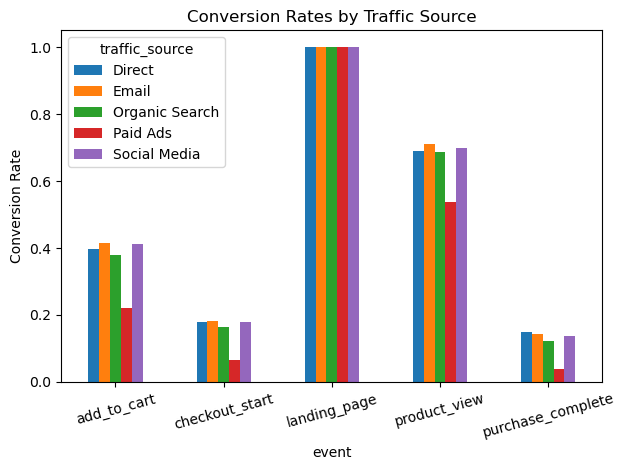

<Figure size 1000x500 with 0 Axes>

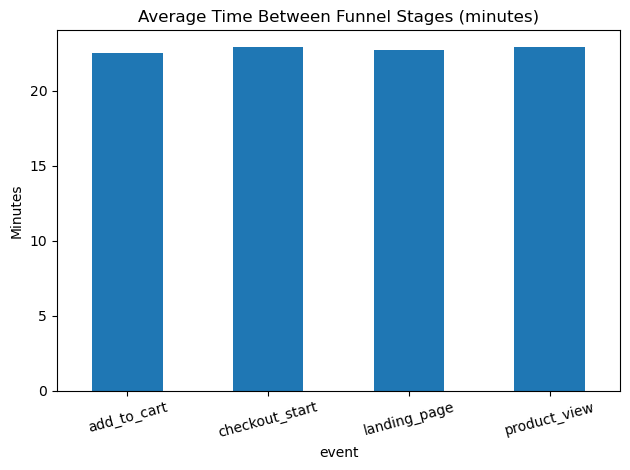

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


print("Loading processed data...")
df = pd.read_csv('processed_funnel_data.csv', parse_dates=['timestamp'])


if 'time_to_next' in df.columns:
    try:
        df['time_to_next'] = pd.to_timedelta(df['time_to_next'])
    except ValueError as e:
        print(f"Warning: Could not convert time_to_next to timedelta: {e}")
        df['time_to_next'] = pd.NaT  # Set to Not-a-Time if conversion fails


print("\n=== Conversion by Device ===")
device_analysis = (
    df.groupby(['device', 'event'])
    .agg(users=('user_id', 'nunique'))
    .reset_index()
    .pivot(index='event', columns='device', values='users')
)


for device in device_analysis.columns:
    device_analysis[f'{device}_conv'] = (
        device_analysis[device] / device_analysis[device].iloc[0]
    ).round(3)

print(device_analysis)


print("\n=== Average Time Between Stages ===")
time_analysis = pd.DataFrame()  

if 'time_to_next' in df.columns and not df['time_to_next'].isna().all():
    try:
        time_analysis = (
            df.dropna(subset=['time_to_next'])
            .groupby('event')
            .apply(lambda x: x['time_to_next'].dt.total_seconds().mean() / 60)
            .round(1)
            .to_frame('avg_time_min')
        )
    except AttributeError:
        
        time_analysis = (
            df.dropna(subset=['time_to_next'])
            .groupby('event')
            .apply(lambda x: pd.to_timedelta(x['time_to_next']).astype('int64').mean() / 1e9 / 60)
            .round(1)
            .to_frame('avg_time_min')
        )
else:
    print("Warning: time_to_next data not available or all NaN")

print(time_analysis)


print("\n=== Drop-off Rates by Traffic Source ===")

traffic_counts = (
    df.groupby(['traffic_source', 'event'])
    .agg(users=('user_id', 'nunique'))
    .reset_index()
)


conversion_rates = []
for source in traffic_counts['traffic_source'].unique():
    source_data = traffic_counts[traffic_counts['traffic_source'] == source]
    first_stage_users = source_data[source_data['event'] == 'landing_page']['users'].values[0]
    source_data['conversion_rate'] = source_data['users'] / first_stage_users
    conversion_rates.append(source_data)

traffic_analysis = pd.concat(conversion_rates)


traffic_pivot = traffic_analysis.pivot(
    index='event', 
    columns='traffic_source', 
    values='conversion_rate'
)

device_analysis.to_csv('device_analysis.csv')
time_analysis.to_csv('time_analysis.csv', index=True)  # Include index for event names
traffic_analysis.to_csv('traffic_analysis_full.csv', index=False)
traffic_pivot.to_csv('traffic_analysis_pivot.csv')


plt.figure(figsize=(12, 6))
traffic_pivot.plot(kind='bar')
plt.title('Conversion Rates by Traffic Source')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('traffic_source_analysis.png', dpi=300)


if not time_analysis.empty:
    plt.figure(figsize=(10, 5))
    time_analysis.plot(kind='bar', legend=False)
    plt.title('Average Time Between Funnel Stages (minutes)')
    plt.ylabel('Minutes')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('time_between_stages.png', dpi=300)

print("\nAdvanced analysis complete!")
print("Results saved to CSV files and visualizations created")